In [139]:
import numpy as np
import scipy.io as io
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from scipy.stats import gaussian_kde
from utils import *
from eeg_feature_extraction.eeg_utils import *
random.seed(42)

In [270]:
files_task2 = get_matfiles('task2')
files_task3 = get_matfiles('task3')

data_task2_sbj1 = io.loadmat(files_task2[0], squeeze_me=True, struct_as_record=False)['sentenceData']
data_task3_sbj1 = io.loadmat(files_task3[0], squeeze_me=True, struct_as_record=False)['sentenceData']

sent_lens_task2_sbj1 = [len(sent.word) for sent in data_task2_sbj1]
sent_lens_task3_sbj1 = [len(sent.word) for sent in data_task3_sbj1]

In [191]:
def truncating(eeg_mat):
    mean_len = np.mean([len(sent) for sent in eeg_mat], dtype=int)
    eeg_mat_padded = np.zeros((eeg_mat.shape[0], mean_len), dtype=float)
    for i, sent in enumerate(eeg_mat):
        if len(sent) <= mean_len:
            eeg_mat_padded[i, :len(sent)] += sent
        else:
            eeg_mat_padded[i, :len(sent)] += sent[:mean_len]
    return eeg_mat_padded

In [192]:
def zero_padding(eeg_mat):
    max_len = max([len(sent) for sent in eeg_mat])
    eeg_mat_padded = np.zeros((eeg_mat.shape[0], max_len), dtype=float)
    for i, sent in enumerate(eeg_mat):
        eeg_mat_padded[i, :len(sent)] += sent
    return eeg_mat_padded

In [172]:
def map_electrode_onto_tensor(eeg_tensor, electrode_idx):
    return np.array(list(map(lambda sent:sent[:, electrode_idx].ravel(), eeg_tensor)))

In [173]:
def reshape_into_tensor(eeg_data_all_sbjs, sent_lens_sbj):
    # get eeg data per sbj (all sentences)
    eeg_data_sbj = eeg_data_all_sbjs[:sum(sent_lens_sbj), :]
    # split eeg data into 3D tensor (N (sentences) x D (words) x K (EEG activity in electrode X for X frequency domain))
    eeg_data_sbj_tensor = []
    # cumulative sent len
    cum_sent_len = 0
    for sent_len in sent_lens_sbj:
        eeg_data_sbj_tensor.append(eeg_data_sbj[cum_sent_len:cum_sent_len+sent_len])
        cum_sent_len += sent_len
    return np.array(eeg_data_sbj_tensor)

In [3]:
eeg_feats_all_sbjs_task2 = np.vstack([get_eeg_features('task2', i, 'most_important', 'avg') for i in range(12)])
eeg_feats_all_sbjs_task3 = np.vstack([get_eeg_features('task3', i, 'most_important', 'avg') for i in range(12)])

In [271]:
eeg_data_per_sent_task2_sbj1 = reshape_into_tensor(eeg_feats_all_sbjs_task2, sent_lens_task2_sbj1)
eeg_data_per_sent_task3_sbj1 = reshape_into_tensor(eeg_feats_all_sbjs_task3, sent_lens_task3_sbj1)

In [4]:
path = os.getcwd() + '\\eeg_feature_extraction\\' + '\\important_eeg_features\\'
files = [os.path.join(path, file) for file in os.listdir(path)]
eeg_locs_all_freqs = [np.loadtxt(file, dtype=int) for file in files]
eeg_locs_alpha_freqs = eeg_locs_all_freqs[:4]
eeg_locs_beta_freqs = eeg_locs_all_freqs[4:8]
eeg_locs_gamma_freqs = eeg_locs_all_freqs[8:12]
eeg_locs_theta_freqs = eeg_locs_all_freqs[12:16]

In [5]:
eeg_electrodes = np.array(['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E9', 'E10', 'E11', 'E12', 'E13', 'E15', 'E16', 'E18', 'E19', 'E20', 'E22', 'E23', 'E24', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E64', 'E65', 'E66', 'E67', 'E69', 'E70', 'E71', 'E72', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E82', 'E83', 'E84', 'E85', 'E86', 'E87', 'E89', 'E90', 'E91', 'E92', 'E93', 'E95', 'E96', 'E97', 'E98', 'E100', 'E101', 'E102', 'E103', 'E104', 'E105', 'E106', 'E108', 'E109', 'E110', 'E111', 'E112', 'E114', 'E115', 'E116', 'E117', 'E118', 'E120', 'E121', 'E122', 'E123', 'E124', 'Cz'])
temporal_electrodes = ['E38', 'E120', 'E114', 'E43']
et_features = ['FFD', 'GD', 'GPT', 'TRT']

In [40]:
#TODO: figure out how one can compute KL (Kullback-Leibler) divergence for this kind of data
#pick random samples since we do not have equally many data points for both tasks (due to different number of sentences)
#max_idx = min(eeg_feats_all_sbjs_task2.shape[0], eeg_feats_all_sbjs_task3.shape[0])
#rnd_indices = random.sample(list(range(0, max_idx)), k=max_idx)
#assert len(rnd_indices) == len(set(rnd_indices))

## $\alpha$-frequency domain

In [199]:
alpha_electrodes_all = [eeg_electrodes[indices] for indices in eeg_locs_alpha_freqs]

temporal_indices_alpha = [np.array([eeg_electrodes[indices].tolist().index(electrod)
                           for electrod in temporal_electrodes]) for indices in eeg_locs_alpha_freqs]

temporal_electrodes_alpha_all = np.array([alpha_electrodes[temporal_indices] 
                                                for alpha_electrodes, temporal_indices 
                                                in zip(alpha_electrodes_all, temporal_indices_alpha)]).ravel()
                                   
temporal_indices_alpha_all = np.array([indices + int(10 * i) for i, indices in enumerate(temporal_indices_alpha)]).ravel()

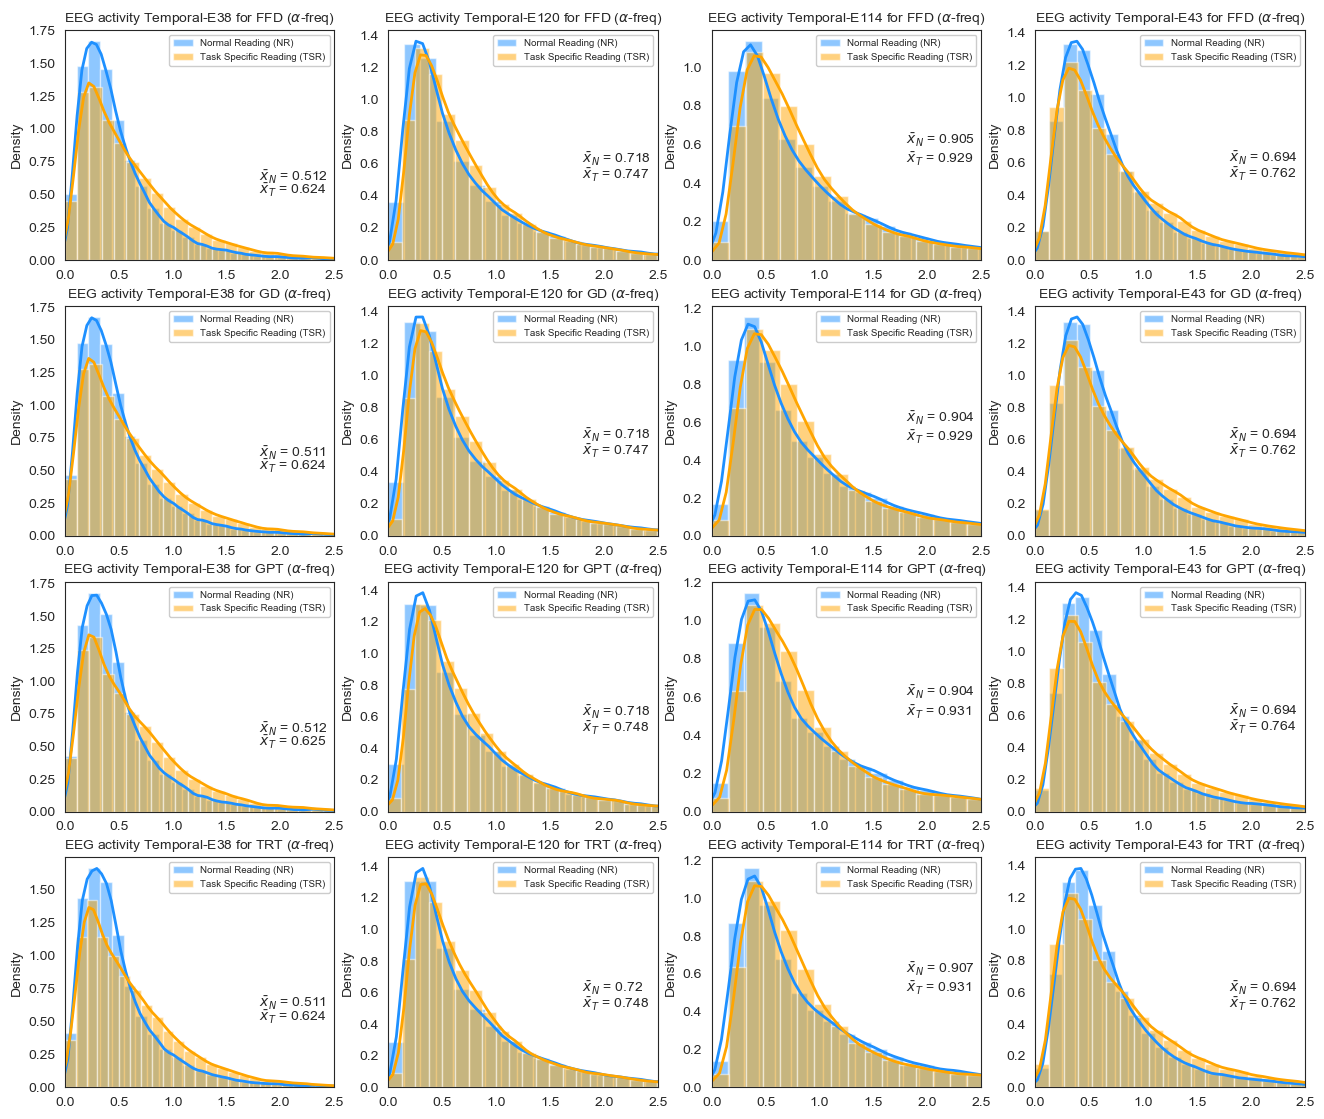

In [98]:
kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_alpha_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_alpha_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_alpha_all[feat]].mean()), (1.8, 0.6))
        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_alpha_all[feat]].mean()), (1.8, 0.5))
        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_features[i]), fontsize = 10)
        axes[i][j].set_ylabel(r'Density')
        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
        axes[i][j].set_xlim(0, 2.5)
        feat += 1
plt.savefig('plots/alpha_activity_temporal')
plt.show()

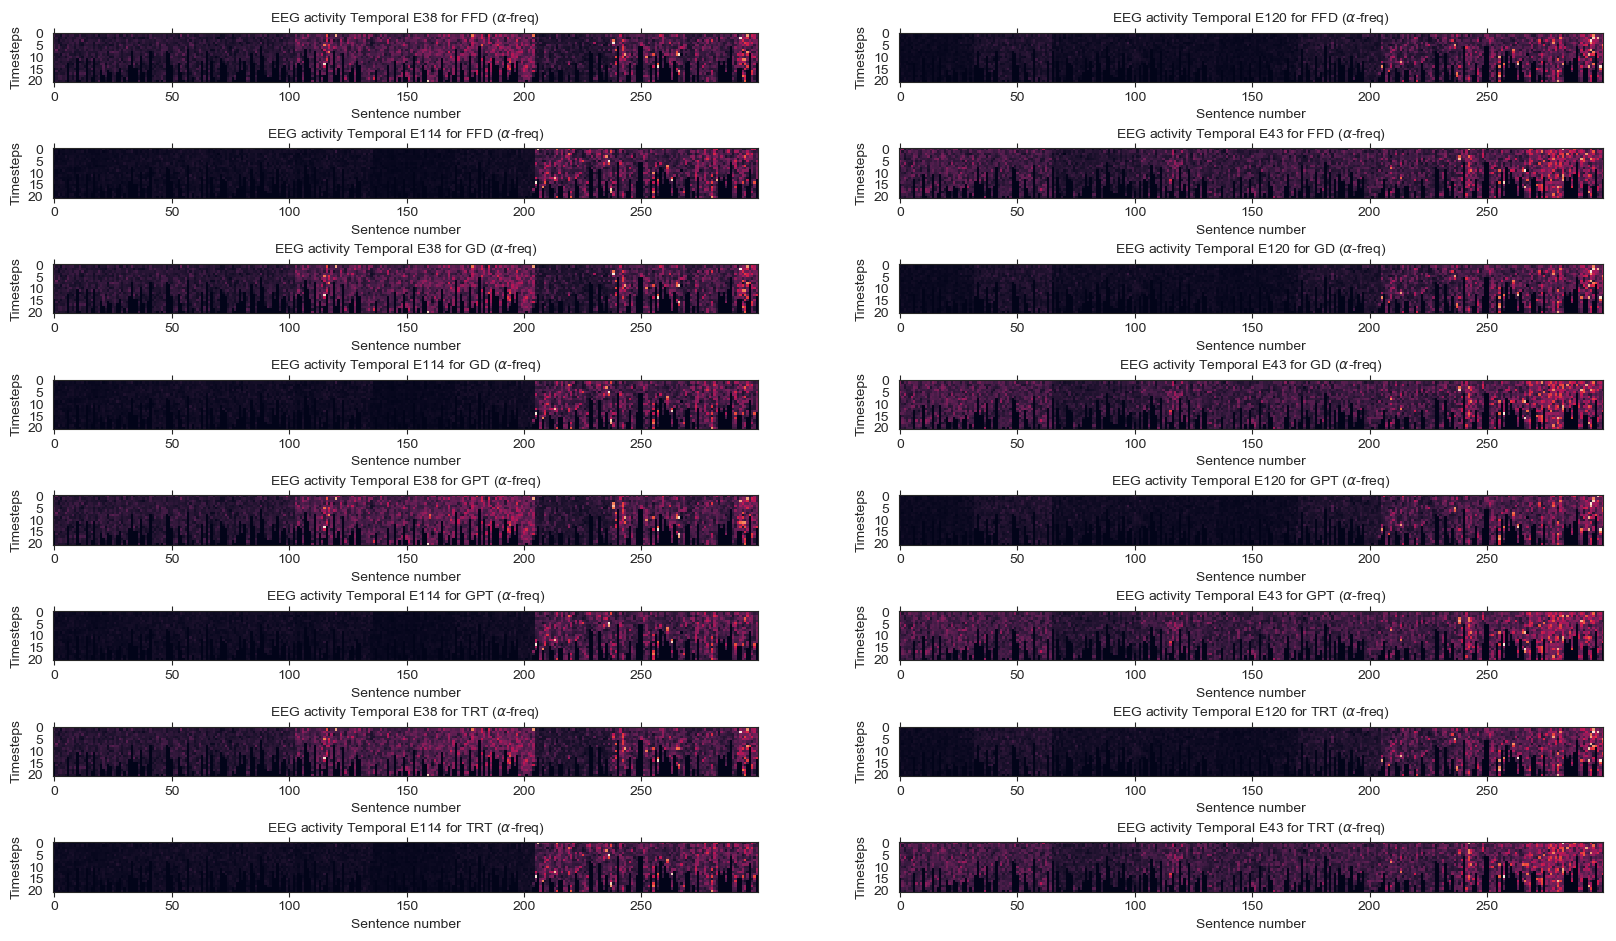

In [317]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(20, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_alpha_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_features[et_feat_idx]), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/alpha_activity_temporal_heatmap_sbj1_task2')
plt.show()

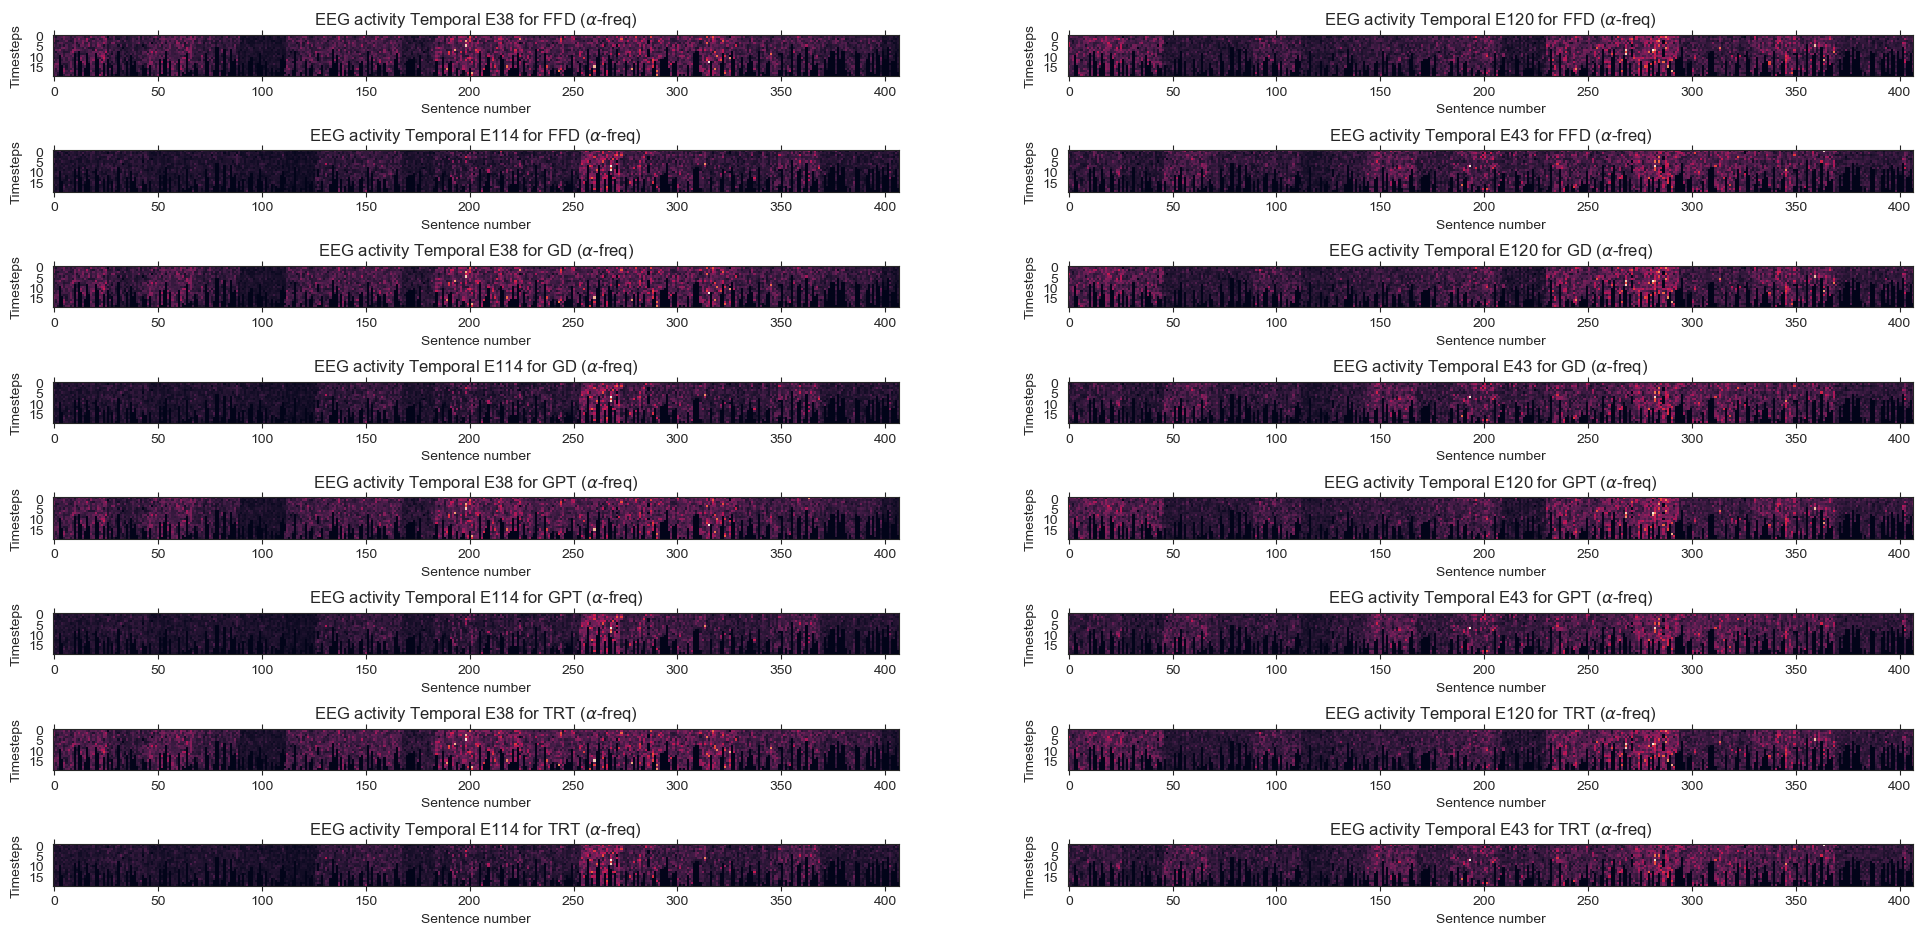

In [318]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(24, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_alpha_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\alpha$-freq)'.format(temporal_electrodes_alpha_all[feat], et_features[et_feat_idx]), fontsize=12)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/alpha_activity_temporal_heatmap_sbj1_task3')
plt.show()

## $\beta$-frequency domain

In [74]:
beta_electrodes_all = [eeg_electrodes[indices] for indices in eeg_locs_beta_freqs]

temporal_indices_beta = [np.array([eeg_electrodes[indices].tolist().index(electrod)
                           for electrod in temporal_electrodes]) for indices in eeg_locs_beta_freqs]

temporal_electrodes_beta_all = np.array([beta_electrodes[temporal_indices] 
                                         for beta_electrodes, temporal_indices 
                                         in zip(beta_electrodes_all, temporal_indices_beta)]).ravel()
                                   
temporal_indices_beta_all = np.array([indices + 40 + int(10 * i) for i, indices in enumerate(temporal_indices_beta)]).ravel()

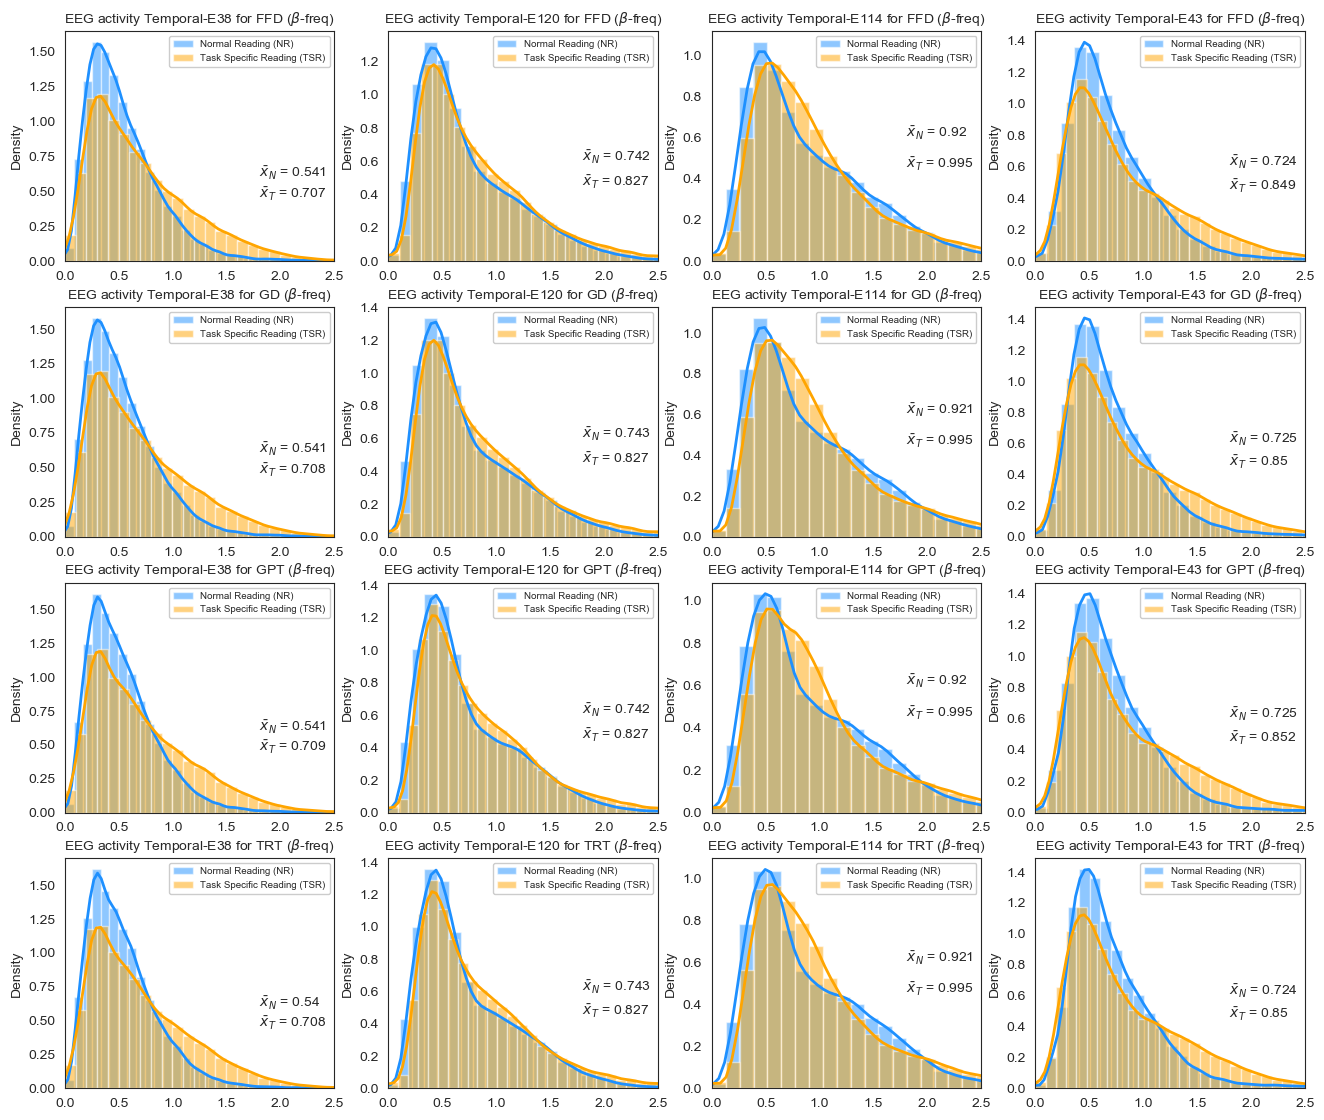

In [89]:
kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_beta_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_beta_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_beta_all[feat]].mean()), (1.8, 0.6))
        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_beta_all[feat]].mean()), (1.8, 0.45))
        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_features[i]), fontsize = 10)
        axes[i][j].set_ylabel(r'Density')
        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
        axes[i][j].set_xlim(0, 2.5)
        feat += 1
plt.savefig('plots/beta_activity_temporal')
plt.show()

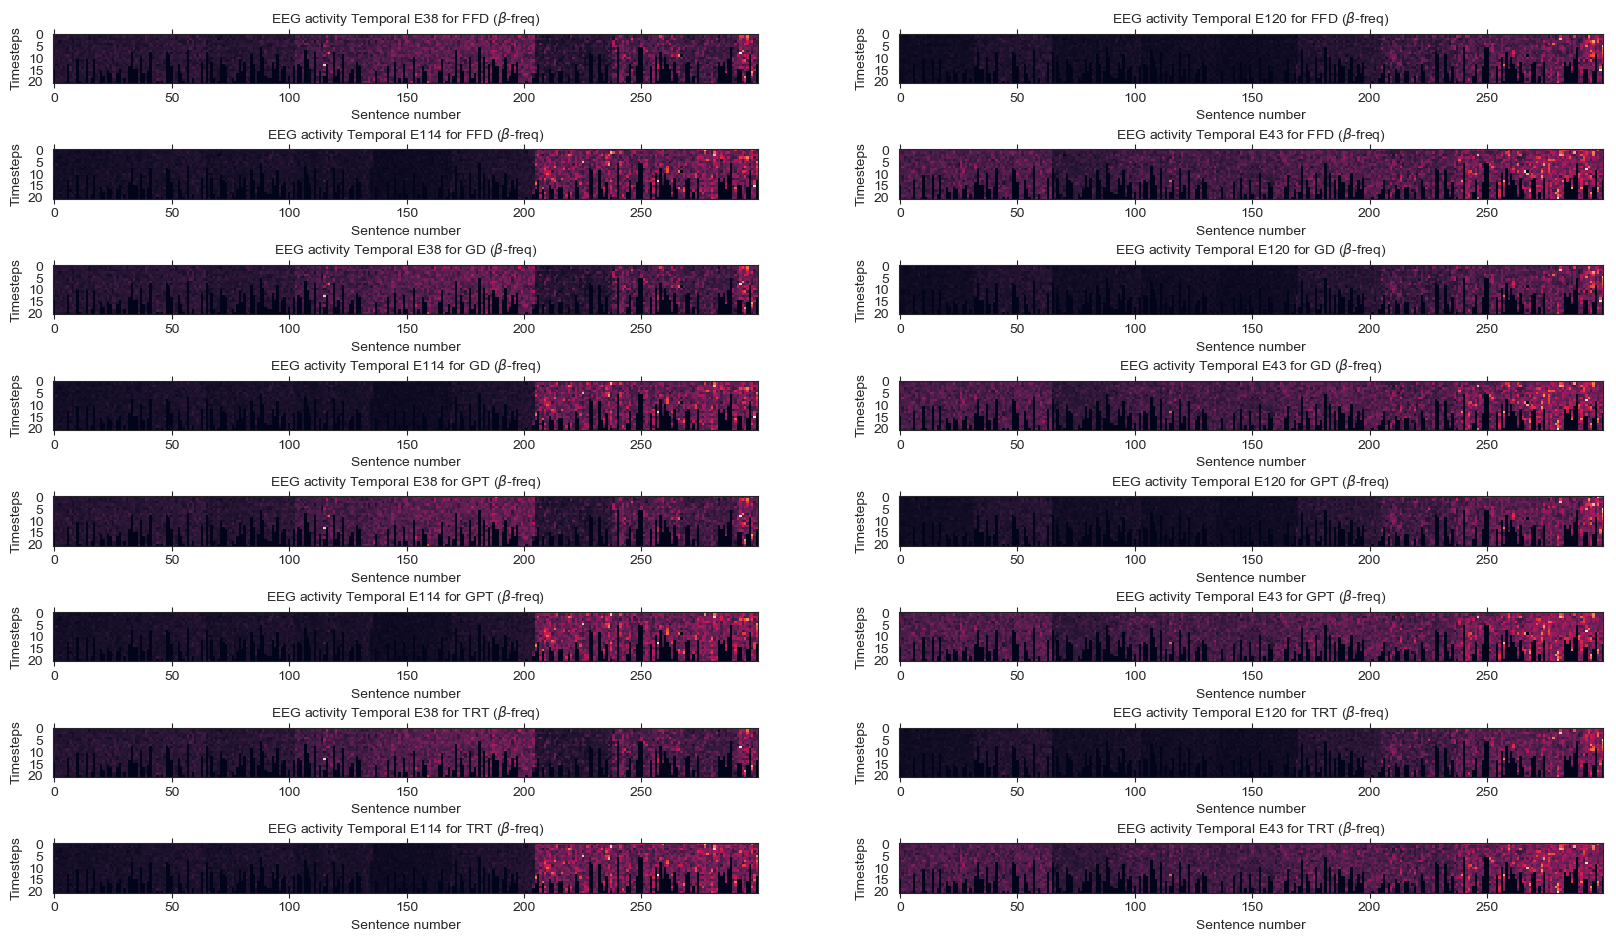

In [304]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(20, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_beta_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_features[et_feat_idx]), fontsize=10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/beta_activity_temporal_heatmap_sbj1_task2')
plt.show()

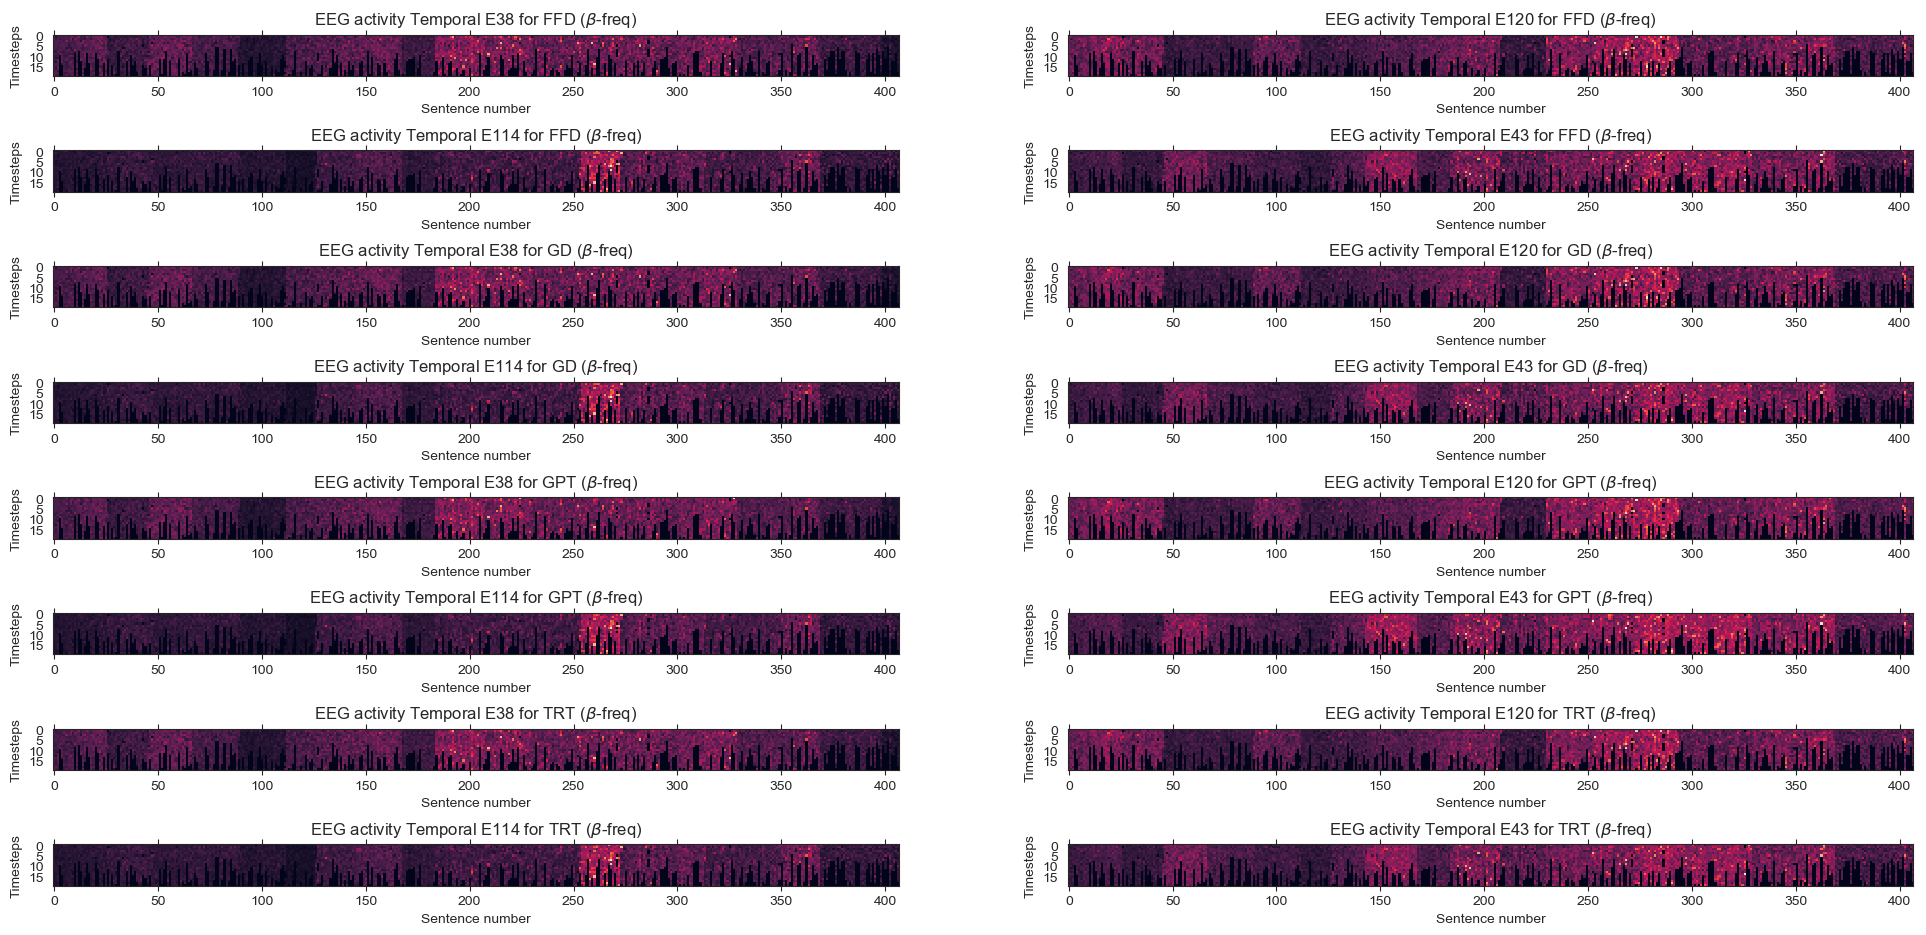

In [315]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(24, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_beta_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\beta$-freq)'.format(temporal_electrodes_beta_all[feat], et_features[et_feat_idx]), fontsize=12)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/beta_activity_temporal_heatmap_sbj1_task3')
plt.show()

## $\gamma$-frequency domain

In [76]:
gamma_electrodes_all = [eeg_electrodes[indices] for indices in eeg_locs_gamma_freqs]

temporal_indices_gamma = [np.array([eeg_electrodes[indices].tolist().index(electrod)
                           for electrod in temporal_electrodes]) for indices in eeg_locs_gamma_freqs]

temporal_electrodes_gamma_all = np.array([gamma_electrodes[temporal_indices] 
                                         for gamma_electrodes, temporal_indices 
                                         in zip(gamma_electrodes_all, temporal_indices_gamma)]).ravel()
                                   
temporal_indices_gamma_all = np.array([indices + 80 + int(10 * i) for i, indices in enumerate(temporal_indices_gamma)]).ravel()

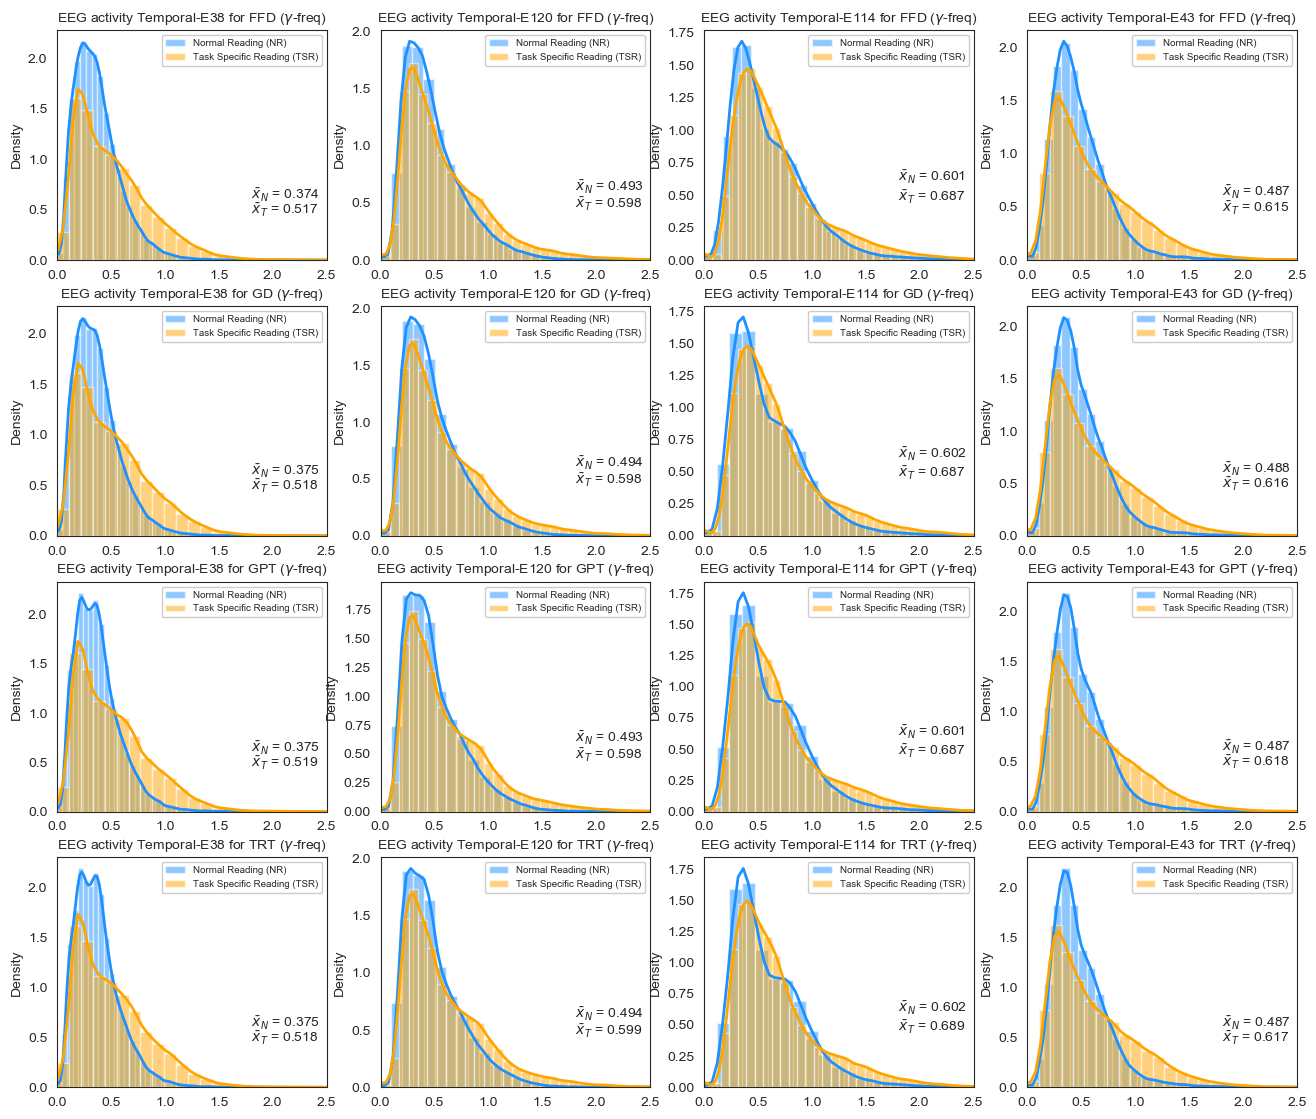

In [90]:
kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_gamma_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_gamma_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_gamma_all[feat]].mean()), (1.8, 0.6))
        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_gamma_all[feat]].mean()), (1.8, 0.45))
        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\gamma$-freq)'.format(temporal_electrodes_gamma_all[feat], et_features[i]), fontsize=10)
        axes[i][j].set_ylabel(r'Density')
        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
        axes[i][j].set_xlim(0, 2.5)
        feat += 1
plt.savefig('plots/gamma_activity_temporal')
plt.show()

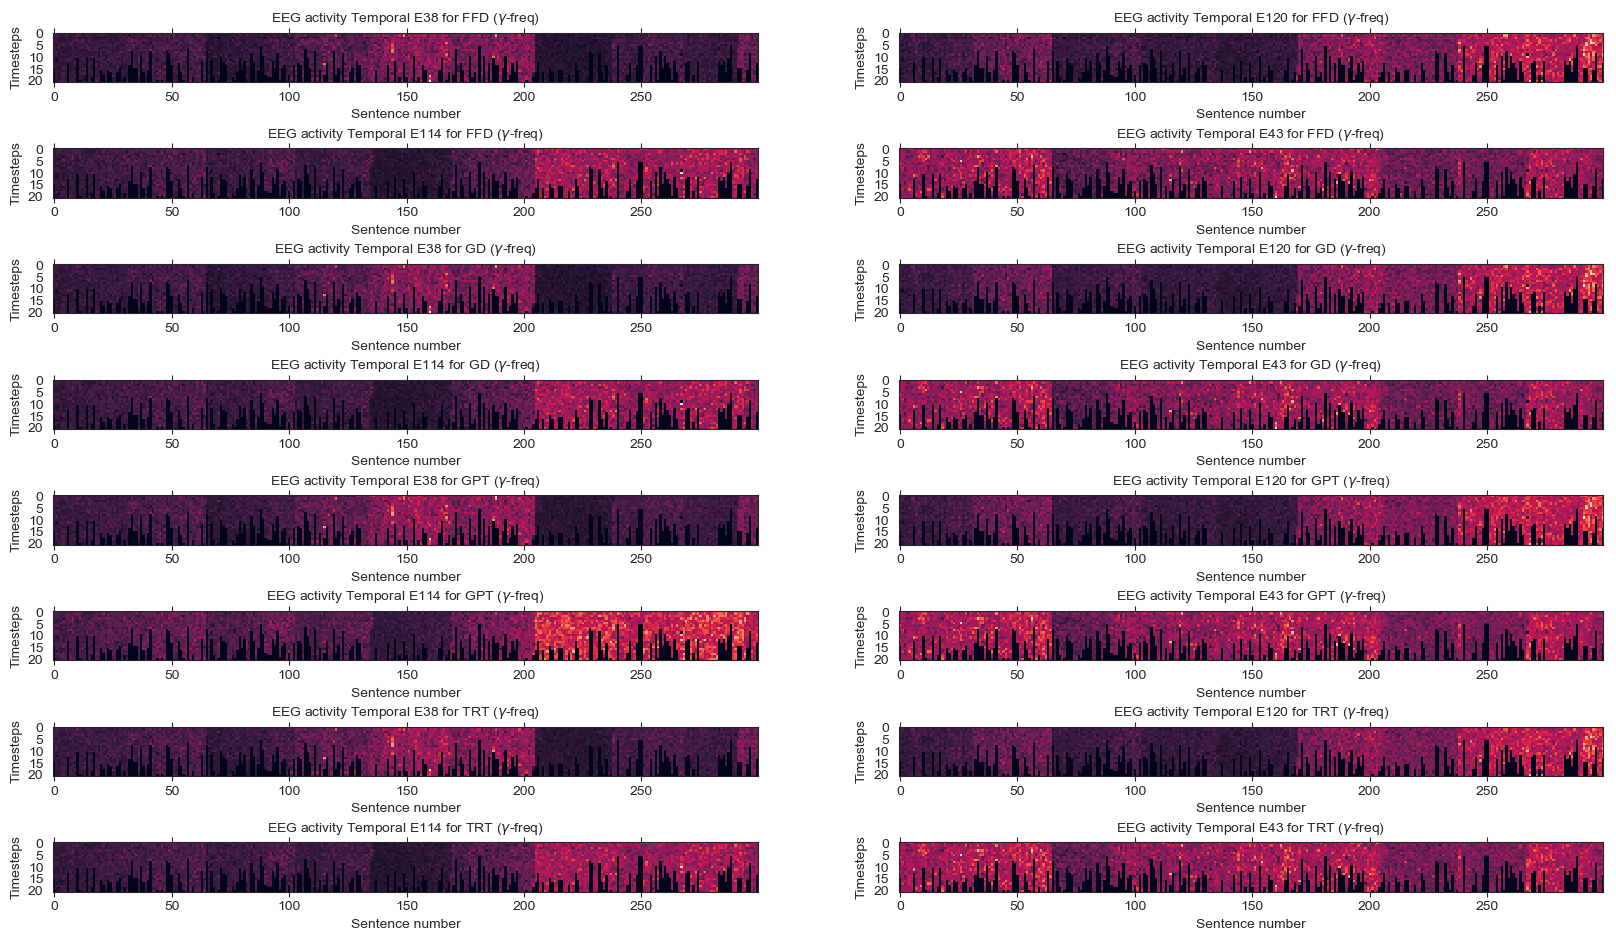

In [319]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(20, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_gamma_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\gamma$-freq)'.format(temporal_electrodes_gamma_all[feat], et_features[et_feat_idx]), fontsize=10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/gamma_activity_temporal_heatmap_sbj1_task2')
plt.show()

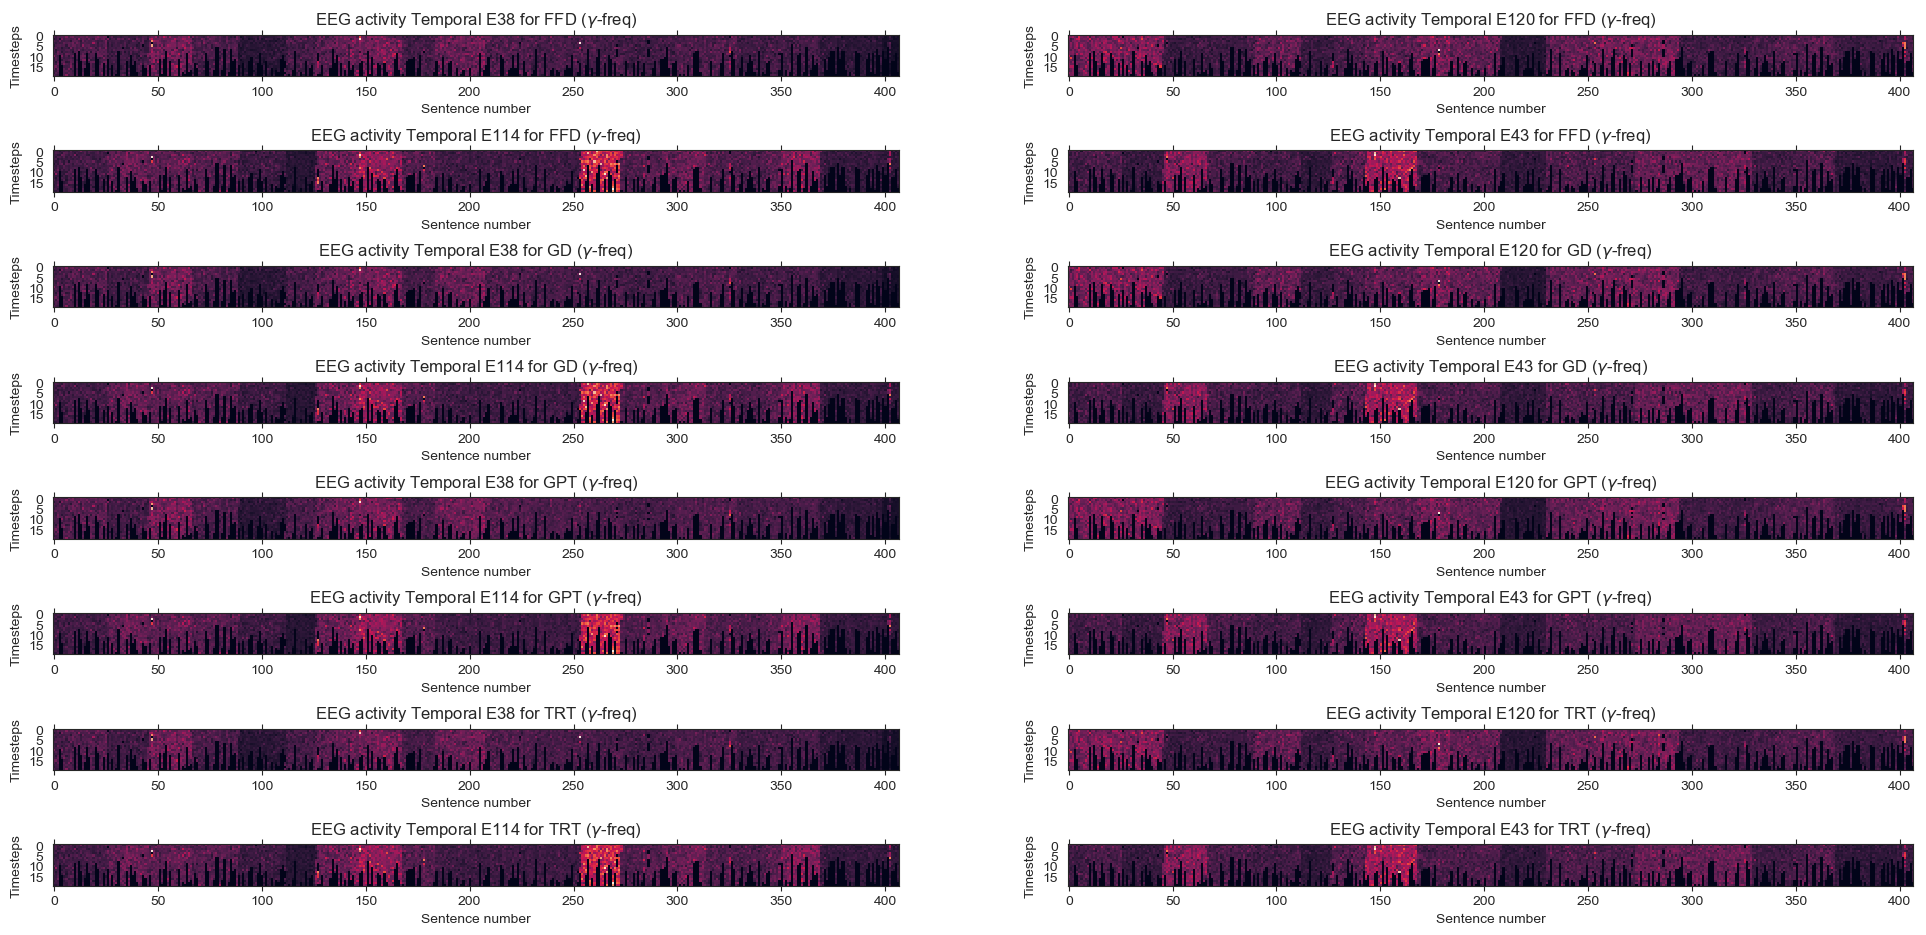

In [320]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(24, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_gamma_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\gamma$-freq)'.format(temporal_electrodes_gamma_all[feat], et_features[et_feat_idx]), fontsize=12)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/gamma_activity_temporal_heatmap_sbj1_task3')
plt.show()

## $\theta$-frequency domain

In [79]:
theta_electrodes_all = [eeg_electrodes[indices] for indices in eeg_locs_theta_freqs]

temporal_indices_theta = [np.array([eeg_electrodes[indices].tolist().index(electrod)
                           for electrod in temporal_electrodes]) for indices in eeg_locs_theta_freqs]

temporal_electrodes_theta_all = np.array([theta_electrodes[temporal_indices] 
                                         for theta_electrodes, temporal_indices 
                                         in zip(theta_electrodes_all, temporal_indices_theta)]).ravel()
                                   
temporal_indices_theta_all = np.array([indices + 120 + int(10 * i) for i, indices in enumerate(temporal_indices_theta)]).ravel()

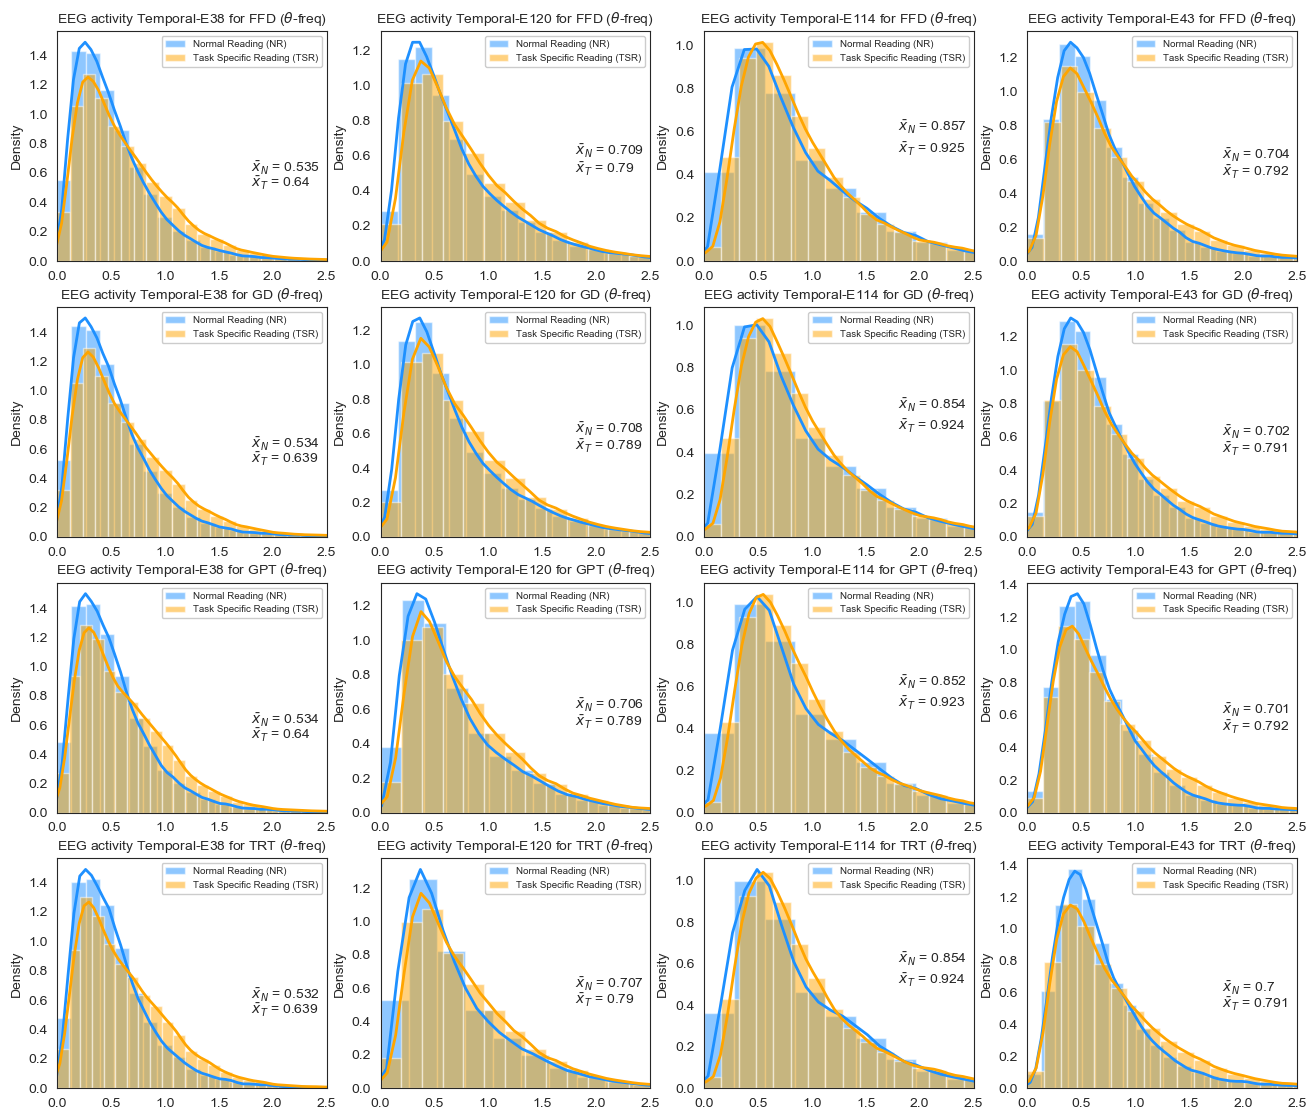

In [91]:
kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

feat = 0
fig, axes = plt.subplots(4, 4, figsize=(16, 14), dpi=100)
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        sns.distplot(eeg_feats_all_sbjs_task2[:, temporal_indices_theta_all[feat]], color="dodgerblue", label="Normal Reading (NR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        sns.distplot(eeg_feats_all_sbjs_task3[:, temporal_indices_theta_all[feat]], color="orange", label="Task Specific Reading (TSR)", kde=True, norm_hist=True, ax=axes[i][j], **kwargs)
        axes[i][j].annotate(r'$\bar x_N$ = {:.3g}'.format(eeg_feats_all_sbjs_task2[:, temporal_indices_theta_all[feat]].mean()), (1.8, 0.6))
        axes[i][j].annotate(r'$\bar x_T$ = {:.3g}'.format(eeg_feats_all_sbjs_task3[:, temporal_indices_theta_all[feat]].mean()), (1.8, 0.5))
        axes[i][j].set_title(r'EEG activity Temporal-{} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_features[i]), fontsize = 10)
        axes[i][j].set_ylabel(r'Density')
        axes[i][j].legend(fancybox=True, framealpha=1, loc='upper right', prop={'size':7})
        axes[i][j].set_xlim(0, 2.5)
        feat += 1
plt.savefig('plots/theta_activity_temporal')
plt.show()

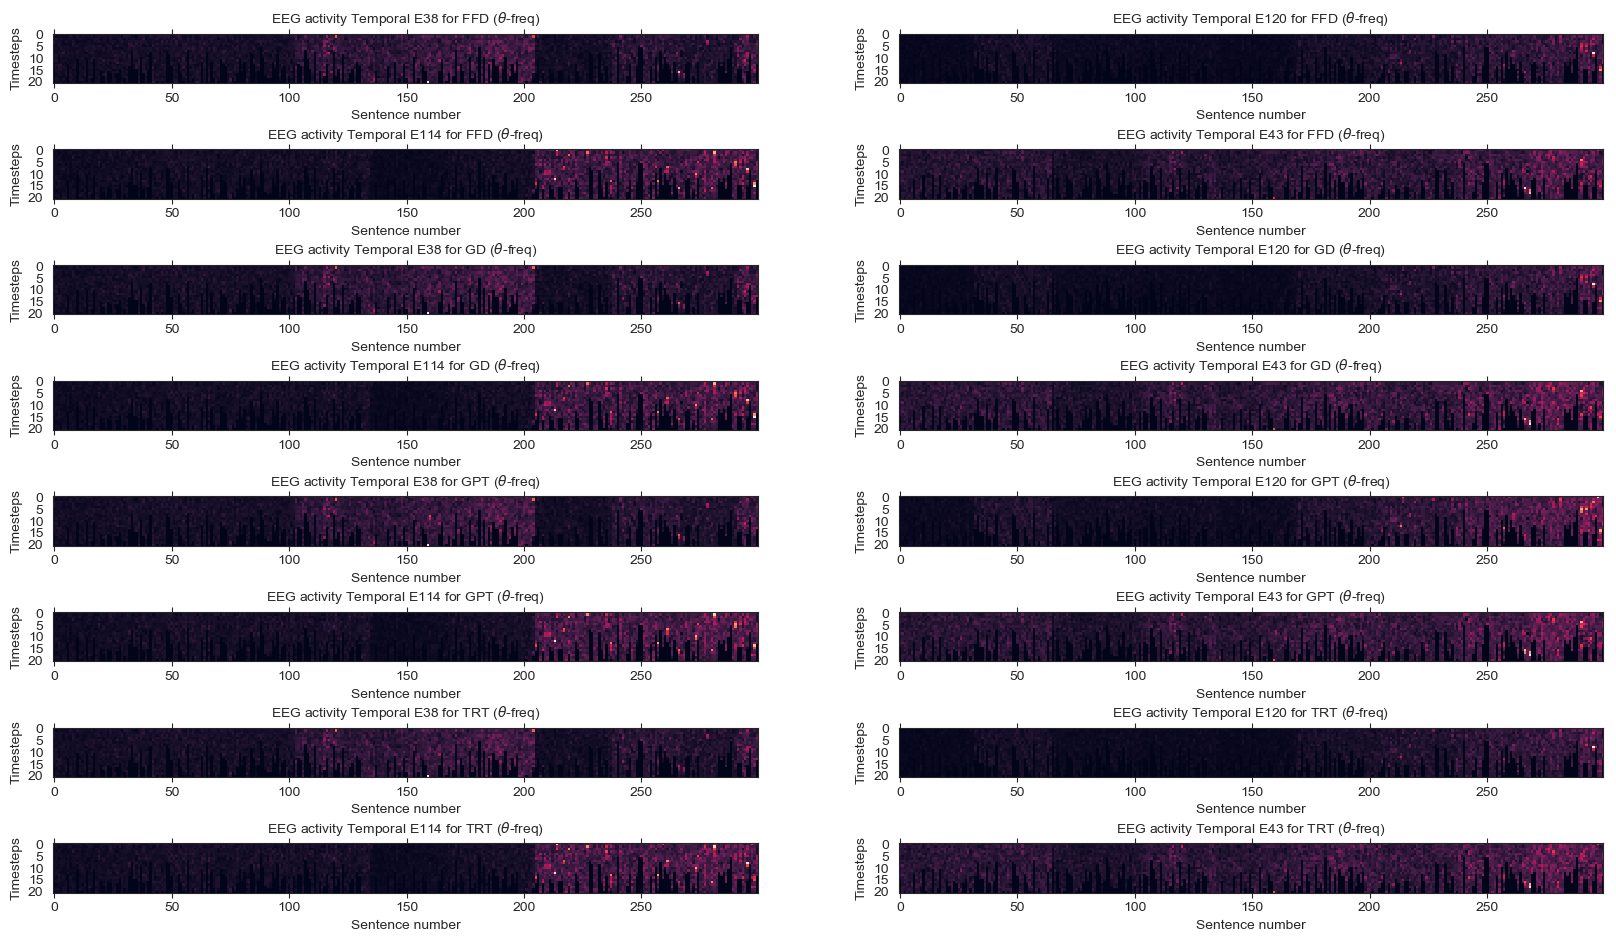

In [321]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(20, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task2_sbj1, temporal_indices_theta_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_features[et_feat_idx]), fontsize = 10)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/theta_activity_temporal_heatmap_sbj1_task2')
plt.show()

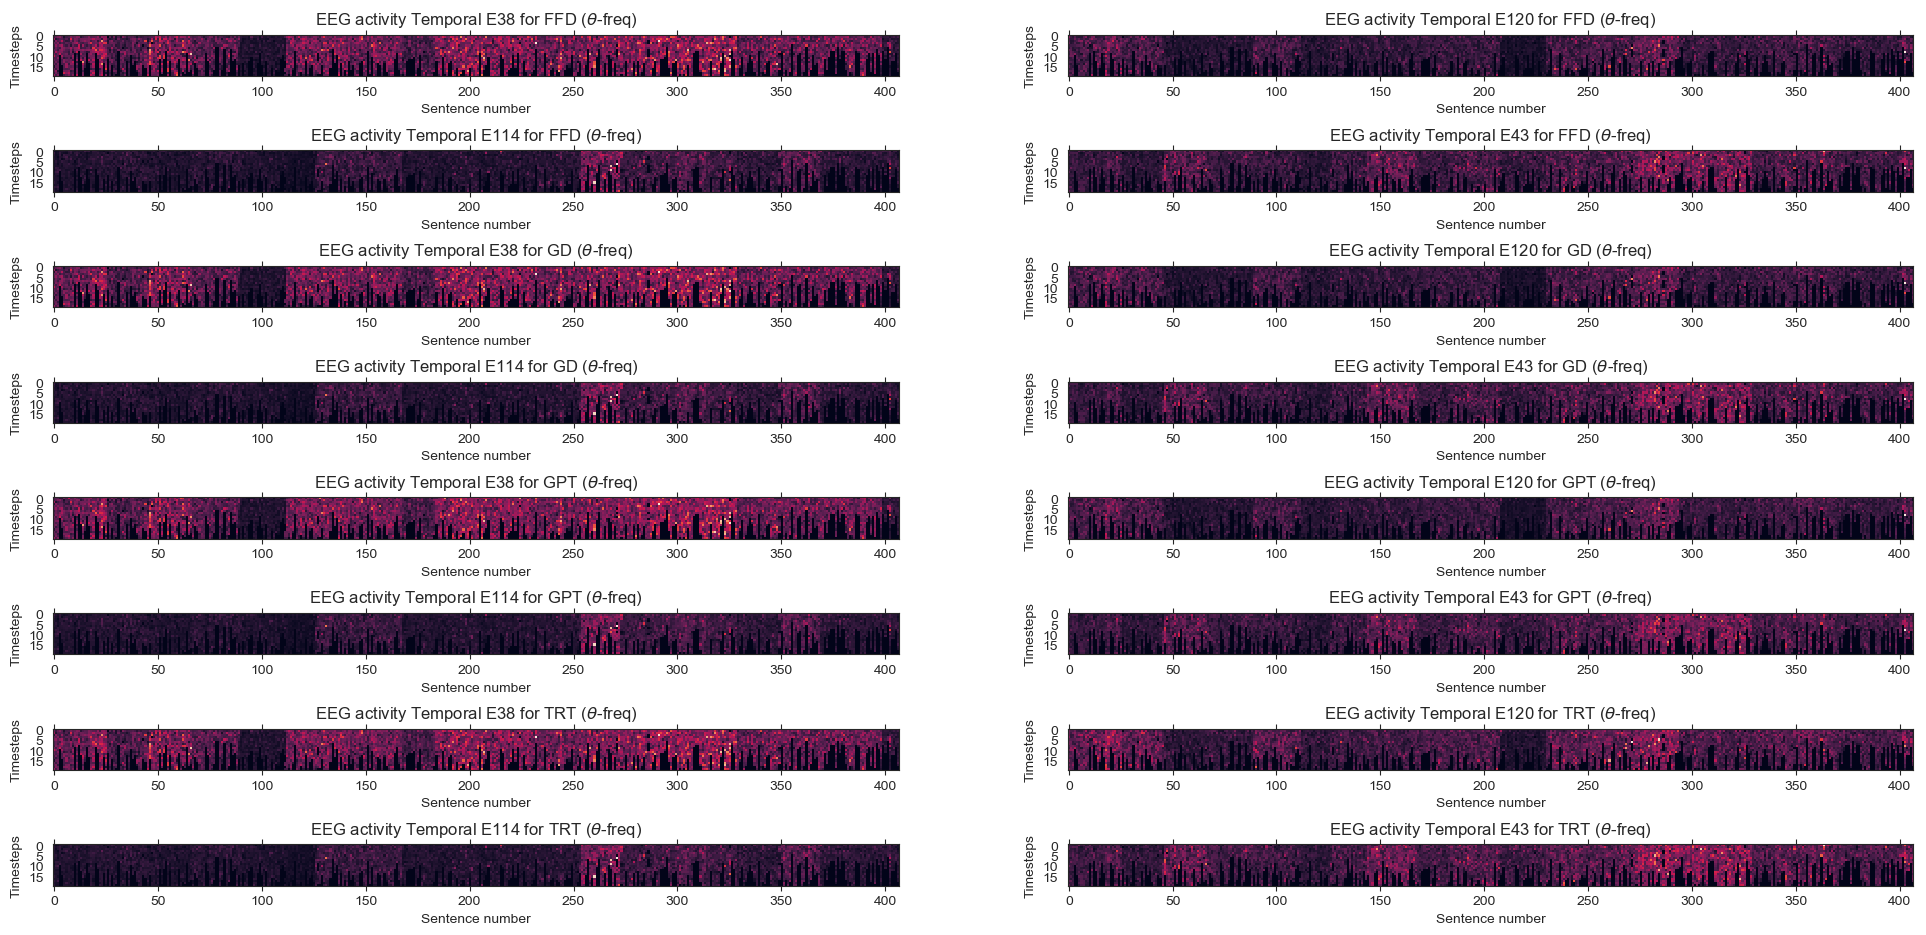

In [323]:
et_feat_idx = 0
feat = 0
fig, axes = plt.subplots(8, 2, figsize=(24, 12), dpi=100)
for i, row in enumerate(axes):
    if (i % 2 == 0) and (i > 0): et_feat_idx += 1
    for j, col in enumerate(row):
        axes[i][j].matshow(truncating(map_electrode_onto_tensor(eeg_data_per_sent_task3_sbj1, temporal_indices_theta_all[feat])).T)
        axes[i][j].set_title(r'EEG activity Temporal {} for {} ($\theta$-freq)'.format(temporal_electrodes_theta_all[feat], et_features[et_feat_idx]), fontsize=12)
        axes[i][j].set_xlabel('Sentence number')
        axes[i][j].set_ylabel('Timesteps')
        axes[i][j].xaxis.set_tick_params(labeltop=False)
        axes[i][j].xaxis.set_tick_params(labelbottom=True)
        feat += 1
plt.savefig('plots/theta_activity_temporal_heatmap_sbj1_task3')
plt.show()